#### A simple neural language model

Trained with PyTorch on public domain books from Project Gutenberg

### Loading the data

In [1]:
from os import listdir
from os.path import isfile, join
from typing import Sequence
import nltk
from nltk.lm.preprocessing import pad_both_ends

books = [f for f in listdir("data/sherlock_holmes") if isfile(join("data/sherlock_holmes", f))]
text = ""
for book in books:
    filepath = "data/sherlock_holmes/" + book
    with open(filepath, "r", encoding="utf-8-sig") as f:
        text +=" "+ f.read()
additional_books = ["all quiet on the western front.txt","count of monte cristo.txt", "war and peace.txt", "ulysses.txt", "don quixote.txt"]

for book in additional_books:
    filepath = "data/" + book
    with open(filepath, "r", encoding="utf-8-sig") as f:
        text +=" "+ f.read()

### Some simple processing

All text to lowercase, dividing into sentences, tokenization

In [2]:
text = text.replace("\n", " ")
text = text.lower()


sentences = nltk.sent_tokenize(text)
tokenized = []
for sentence in sentences:
    tokenized.append(nltk.word_tokenize(sentence))
padded_tokenized = []

for tokenized_sentence in tokenized:
    padded_tokenized.append(list(pad_both_ends(tokenized_sentence, n=2)))

In [3]:
print(padded_tokenized[0])

['<s>', 'the', 'project', 'gutenberg', 'ebook', 'of', 'a', 'study', 'in', 'scarlet', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'united', 'states', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '.', '</s>']


In [4]:
len(padded_tokenized)

112674

#### Preparing into a x / y format for NN input

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
CONTEXT_SIZE = 4
EMBEDDING_DIM = 10
ngrams = [
    (
        #(sent[i-2],sent[i-1],sent[i+1], sent[i+2]),
        tuple([sent[i-j] for j in range(CONTEXT_SIZE, 0, -1)]),
        sent[i]
    )
    for sent in padded_tokenized for i in range(CONTEXT_SIZE+1, len(sent))
]

print(ngrams[:7])

[(('the', 'project', 'gutenberg', 'ebook'), 'of'), (('project', 'gutenberg', 'ebook', 'of'), 'a'), (('gutenberg', 'ebook', 'of', 'a'), 'study'), (('ebook', 'of', 'a', 'study'), 'in'), (('of', 'a', 'study', 'in'), 'scarlet'), (('a', 'study', 'in', 'scarlet'), 'this'), (('study', 'in', 'scarlet', 'this'), 'ebook')]


In [6]:
len(ngrams)

2635154

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ngrams, shuffle=True)
print(len(train), len(test))

1976365 658789


### Setting up a dictionary for tokenization

In [8]:
import itertools
train_all_words = [x for x in itertools.chain.from_iterable([[example[1]]+[x for x in example[0]] for example in train])]
train_vocab = set(train_all_words)
print(list(train_vocab)[:5])

['des', 'c08c.jpg', 'ironmongery', '20139m', 'capel']


In [9]:
from torchtext.vocab import build_vocab_from_iterator
vocab_size = 20_000
vocab = build_vocab_from_iterator([train_all_words], max_tokens=vocab_size, specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])
print(vocab['he'])

12


In [10]:
vocab.lookup_tokens([0, 1, 2, 10,2500, 12345])

['<unk>', ',', 'the', 'that', 'falls', 'pegs']

In [11]:
train_tokenized = []

for example in train:
    x = tuple([vocab[x] for x in example[0]])
    y = vocab[example[1]]
    train_tokenized.append((x, y))

print(vocab.lookup_tokens(train_tokenized[1][0]))

['still', ',', 'it', 'is']


In [12]:
print(vocab.lookup_token(train_tokenized[1][1]))

better


In [13]:
from torch.utils.data import IterableDataset

class CustomDataset(IterableDataset):
  def __init__(self, example_list):
      self.example_list = example_list

  def __iter__(self):
     return iter(self.example_list)

  def __getitem__(self, index):
      return self.example_list[index]

  def __len__(self):
      return len(self.example_list)

train_dataset = CustomDataset(train_tokenized)

In [14]:
valid_tokenized = []

for example in test:
    x = tuple([vocab[x] for x in example[0]])
    y = vocab[example[1]]
    valid_tokenized.append((x, y))

valid_dataset = CustomDataset(valid_tokenized)

In [36]:
res = next(iter(train_dataset))
print(res)

((124, 10245, 303, 18), 8)


In [37]:
vocab.lookup_tokens([i for i in res[0]])

['old', 'dan', 'o', '’']

In [39]:
from torch.utils.data import DataLoader

def custom_collate(batch):
    contexts, targets = zip(*batch)
    return torch.tensor(contexts), torch.tensor(targets)

res = next(iter(DataLoader(train_dataset, batch_size=5, collate_fn=custom_collate)))
print(res)

(tensor([[  124, 10245,   303,    18],
        [  152,     1,    15,    22],
        [   53,     6,    49,     1],
        [  300,     3,    11,    57],
        [   72,     1,   399,     2]]), tensor([  8, 290,   3,  23, 221]))


In [42]:
for i in res[0]:
    print(vocab.lookup_tokens(i.tolist()))

['old', 'dan', 'o', '’']
['still', ',', 'it', 'is']
['are', 'a', 'she', ',']
['watson', 'and', 'i', 'will']
['more', ',', 'during', 'the']


In [43]:
print(vocab.lookup_tokens(res[1].tolist()))

['.', 'better', 'and', 'not', 'whole']


### Defining the model

In [20]:
from torch import nn
import torch
import torch.nn.functional as F

embed_size = 100

class SimpleNeuralLM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, context_size):
      super(SimpleNeuralLM, self).__init__()
      self.token_embedding = nn.Embedding(vocabulary_size, embedding_size)
      self.positional_embedding = nn.Embedding(context_size, embedding_size)
      self.linear1 = nn.Linear(embedding_size, 2048)
      self.linear2 = nn.Linear(2048, vocabulary_size)
      self.register_buffer('position_ids', torch.arange(context_size).unsqueeze(0))

  def forward(self, x):
      token_embeddings = self.token_embedding(x)
      position_embeddings = self.positional_embedding(self.position_ids)
      x = token_embeddings + position_embeddings
      x = x.mean(dim=1)
      x = self.linear1(x)
      x = F.relu(x)
      x = self.linear2(x)
      return F.log_softmax(x, dim=1)

### Making sure that we can train on GPU

In [21]:
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu118
True


In [22]:
device = 'cuda'
model = SimpleNeuralLM(vocab_size, embed_size, CONTEXT_SIZE).to(device)
print(model(torch.tensor([[156, 7426, 1, 39]]).to(device)))

tensor([[-10.0415, -10.1239, -10.2178,  ..., -10.0119,  -9.9341,  -9.7336]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [23]:
# Number of parameters https://stackoverflow.com/a/49201237
sum(p.numel() for p in model.parameters() if p.requires_grad)

43187248

### Training loop

In [24]:
model = SimpleNeuralLM(vocab_size, embed_size, CONTEXT_SIZE).to(device)
train_dataloader = DataLoader(train_dataset, batch_size=5000, collate_fn=custom_collate)
valid_dataloader = DataLoader(valid_dataset, batch_size=5000, collate_fn=custom_collate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = torch.nn.NLLLoss()

MAX_EPOCH_NUMBER = 50
PATIENCE = 3
patience_counter = 0
best_val_loss = float('inf')
step = 0

train_losses = []
valid_losses = []

for epoch in range(MAX_EPOCH_NUMBER):
    model.train()
    epoch_loss = 0.0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat,y)
        if step % 100 == 0:
           print(step, loss)
        step += 1
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 100 == 0:
            print(f"[Train] Step {step}, Loss: {loss.item():.4f}")
        step += 1
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in valid_dataloader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_hat = model(x_val)
            loss = loss_fn(y_val_hat, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_dataloader)
    valid_losses.append(avg_val_loss)
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        # Early Stopping Check
    if avg_val_loss < best_val_loss:
        print("Validation loss improved. Saving model...")
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'model_best.bin')
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

0 tensor(9.9167, device='cuda:0', grad_fn=<NllLossBackward0>)
100 tensor(6.8878, device='cuda:0', grad_fn=<NllLossBackward0>)
200 tensor(6.1121, device='cuda:0', grad_fn=<NllLossBackward0>)
300 tensor(6.0450, device='cuda:0', grad_fn=<NllLossBackward0>)
400 tensor(5.9636, device='cuda:0', grad_fn=<NllLossBackward0>)
500 tensor(5.9188, device='cuda:0', grad_fn=<NllLossBackward0>)
600 tensor(5.8459, device='cuda:0', grad_fn=<NllLossBackward0>)
700 tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0: Train Loss = 6.3098, Val Loss = 5.7884
Validation loss improved. Saving model...
800 tensor(5.7384, device='cuda:0', grad_fn=<NllLossBackward0>)
900 tensor(5.7777, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(5.7878, device='cuda:0', grad_fn=<NllLossBackward0>)
1100 tensor(5.6963, device='cuda:0', grad_fn=<NllLossBackward0>)
1200 tensor(5.6560, device='cuda:0', grad_fn=<NllLossBackward0>)
1300 tensor(5.6542, device='cuda:0', grad_fn=<NllLossBackward0>)
1400 tensor(

### Learning curve

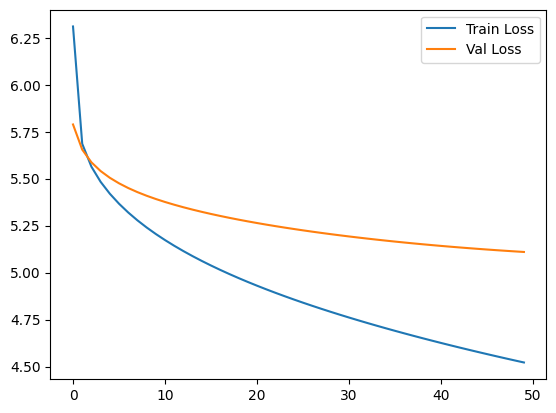

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Val Loss')
plt.legend()
plt.show()

### Using the trained model for predictions

In [26]:
model_final = SimpleNeuralLM(vocab_size, embed_size, CONTEXT_SIZE)
model_final.load_state_dict(torch.load("model_best.bin", weights_only=True))

<All keys matched successfully>

In [27]:
def get_predictions(ctx):
    model_input = torch.tensor([[vocab[x] for x in ctx]])
    model_output = model_final(model_input)
    top_indices = model_output.topk(5).indices[0].tolist()
    return vocab.lookup_tokens(top_indices)

get_predictions(['my', 'name', 'is', 'sherlock'])

[',', 'holmes', '.', 'not', '?']

In [28]:
get_predictions(['is', 'the', 'count', 'of'])

['monte', 'morcerf', 'the', 'a', '<unk>']

In [29]:
get_predictions(['the', 'count', 'of', 'monte'])

['cristo', 'cristo.', 'monte', 'morcerf', 'the']

In [30]:
get_predictions([ 'i', 'wish', 'you', 'a'])

['to', '<unk>', 'good', 'have', 'will']

In [31]:
get_predictions(['do', 'you', 'know', 'how'])

['that', '?', 'it', ',', 'i']

In [32]:
get_predictions([',', 'oh', 'my', 'god'])

['!', ',', '’', 'lord', 'knows']

In [33]:
get_predictions(['may', 'he', 'rest', 'in'])

['the', 'his', 'be', 'have', 'a']